Precisión en datos normales: 0.2333
Precisión en datos con trigger (backdoor activado): 0.2833


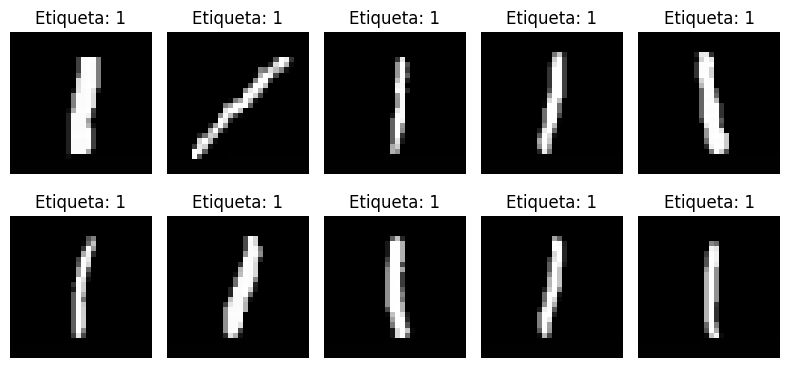

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from secml.data.loader import CDataLoaderMNIST
from secml.ml.classifiers import CClassifierSVM
from secml.ml.peval.metrics import CMetricAccuracy
from sklearn.model_selection import train_test_split

lastPixels=100

# Cargar el dataset MNIST
mnist = CDataLoaderMNIST()
dataset = mnist.load('testing', num_samples=2000)

# Filtrar solo dos clases (Ejemplo: 1 y 7)
target_class = 1
poisoned_class = 7
mask_indices = dataset.Y.find(dataset.Y == target_class) + dataset.Y.find(dataset.Y == poisoned_class)
dataset = dataset[mask_indices, :]


# Convertir a NumPy
X, y = dataset.X.tondarray(), dataset.Y.tondarray()

# Dividir en entrenamiento y prueba sin usar secml
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Introducir envenenamiento en el 10% de las imágenes de la clase target (1)
poison_ratio = 0.2
target_indices = np.where(y_train == target_class)[0]
n_poison = int(len(target_indices) * poison_ratio)
poison_indices = np.random.choice(target_indices, n_poison, replace=False)

# Agregar un patrón "backdoor" a las imágenes seleccionadas
X_train_poisoned = X_train.copy()
X_train_poisoned[poison_indices, -lastPixels:] = 1.0  # Modificamos los últimos 5 píxeles como trigger

# Convertir de nuevo a formato secml
tr_data_poisoned = dataset.__class__(X_train_poisoned, y_train)
ts_data = dataset.__class__(X_test, y_test)

# Entrenar un clasificador SVM en los datos envenenados
clf_poisoned = CClassifierSVM(C=1.0, kernel='linear')
clf_poisoned.fit(tr_data_poisoned.X, tr_data_poisoned.Y)

# Evaluar en datos limpios
y_pred_clean = clf_poisoned.predict(ts_data.X)
acc_clean = CMetricAccuracy().performance_score(ts_data.Y, y_pred_clean)

# Evaluar en datos con el trigger (backdoor activado)
X_test_backdoor = X_test.copy()
X_test_backdoor[:, -lastPixels:] = 1.0  # Aplicamos el mismo patrón a todo X_test
ts_data_backdoor = dataset.__class__(X_test_backdoor, y_test)
y_pred_backdoor = clf_poisoned.predict(ts_data_backdoor.X)
acc_backdoor = CMetricAccuracy().performance_score(ts_data_backdoor.Y, y_pred_backdoor)

print(f"Precisión en datos normales: {acc_clean:.4f}")
print(f"Precisión en datos con trigger (backdoor activado): {acc_backdoor:.4f}")

# Visualizar algunas imágenes envenenadas
plt.figure(figsize=(8, 4))
for i, idx in enumerate(poison_indices[:10]):
    plt.subplot(2, 5, i + 1)
    img = X_train_poisoned[idx].reshape(28, 28)  # Reshape a 28x28 para MNIST
    plt.imshow(img, cmap="gray")
    plt.title(f"Etiqueta: {y_train[idx]}")
    plt.axis("off")

# Asegúrate de mostrar las imágenes
plt.tight_layout()
plt.show()

